In [ ]:
# 04_phase6_report.ipynb

# ======================
# Phase 6 - Final Report
# ======================

# Import necessary libraries
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set consistent plotting style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# ================================
# Step 1 - Load Metrics per Client
# ================================

# Path to results folder
results_dir = 'results/'
metric_files = [f for f in os.listdir(results_dir) if f.startswith('metrics_client') and f.endswith('.json')]

# Initialize an empty list to collect all client metrics
all_metrics = []

# Load each client's JSON metrics into a list of dictionaries
for f in metric_files:
    with open(os.path.join(results_dir, f), 'r') as infile:
        data = json.load(infile)
        data['client'] = f.split('_')[1].split('.')[0]  # Extract client ID (e.g., client0)
        all_metrics.append(data)

# Convert to a DataFrame for easier analysis
df = pd.DataFrame(all_metrics)

# Melt the DataFrame to long format for plotting
mae_df = df.melt(id_vars='client', value_vars=[col for col in df.columns if 'mae' in col],
                 var_name='model', value_name='mae')
rmse_df = df.melt(id_vars='client', value_vars=[col for col in df.columns if 'rmse' in col],
                  var_name='model', value_name='rmse')

# Clean model names
mae_df['model'] = mae_df['model'].str.replace('_mae', '').str.upper()
rmse_df['model'] = rmse_df['model'].str.replace('_rmse', '').str.upper()


In [ ]:
# ===========================
# Step 2 - Plot MAE and RMSE
# ===========================

# Plot MAE comparison
plt.figure()
sns.barplot(data=mae_df, x='client', y='mae', hue='model')
plt.title("MAE Comparison Across Clients")
plt.ylabel("Mean Absolute Error")
plt.savefig(os.path.join(results_dir, 'plots', 'mae_comparison.png'))
plt.show()

# Plot RMSE comparison
plt.figure()
sns.barplot(data=rmse_df, x='client', y='rmse', hue='model')
plt.title("RMSE Comparison Across Clients")
plt.ylabel("Root Mean Squared Error")
plt.savefig(os.path.join(results_dir, 'plots', 'rmse_comparison.png'))
plt.show()

In [ ]:
# =================================
# Step 3 - Visualize XAI Attributes
# =================================

# Example for client0 using LSTM attributions
client_id = 'client0'
xai_dir = 'explanations/'

# Load numpy array of attributions
lstm_attr = np.load(os.path.join(xai_dir, f"{client_id}_lstm_attr.npy"))

# Plot heatmap of average attributions across all time steps
avg_attr = lstm_attr.mean(axis=0)  # shape: (timesteps, features)
plt.figure()
sns.heatmap(avg_attr.T, cmap='viridis', xticklabels=5)
plt.title(f"{client_id.upper()} - LSTM Feature Attribution Heatmap")
plt.xlabel("Time Step")
plt.ylabel("Feature Index")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'plots', f'{client_id}_lstm_attr_heatmap.png'))
plt.show()

In [ ]:
# ==================================
# Step 4 - Plot Simplicity & Fidelity
# ==================================

# Assuming simplicity and fidelity metrics are added in the JSON files:
# Example format:
# {
#   "lstm_rmse": 0.32,
#   "gcn_rmse": 0.35,
#   "gat_rmse": 0.30,
#   "lstm_mae": 0.25,
#   ...
#   "gat_fidelity": 0.92,
#   "gcn_fidelity": 0.89,
#   "gat_simplicity": 0.77,
#   ...
# }

# Extract metrics
fidelity_data = []
simplicity_data = []

for row in all_metrics:
    client = row['client']
    for model in ['lstm', 'gcn', 'gat']:
        if f'{model}_fidelity' in row:
            fidelity_data.append({
                'client': client,
                'model': model.upper(),
                'fidelity': row[f'{model}_fidelity']
            })
        if f'{model}_simplicity' in row:
            simplicity_data.append({
                'client': client,
                'model': model.upper(),
                'simplicity': row[f'{model}_simplicity']
            })

fidelity_df = pd.DataFrame(fidelity_data)
simplicity_df = pd.DataFrame(simplicity_data)

# Plot fidelity boxplot
plt.figure()
sns.boxplot(data=fidelity_df, x='model', y='fidelity')
plt.title("Fidelity of Explanations per Model")
plt.savefig(os.path.join(results_dir, 'plots', 'fidelity_boxplot.png'))
plt.show()

# Plot simplicity boxplot
plt.figure()
sns.boxplot(data=simplicity_df, x='model', y='simplicity')
plt.title("Simplicity of Explanations per Model")
plt.savefig(os.path.join(results_dir, 'plots', 'simplicity_boxplot.png'))
plt.show()


In [ ]:
# ===================================================
# Step 5 - Analyze Communication vs. Performance (Optional)
# ===================================================

# Example: communication cost per model/client saved in JSON
# Key: gat_comm_rounds, gcn_comm_rounds, lstm_comm_rounds

comm_vs_perf = []

for row in all_metrics:
    client = row['client']
    for model in ['lstm', 'gcn', 'gat']:
        comm_key = f'{model}_comm_rounds'
        rmse_key = f'{model}_rmse'
        if comm_key in row and rmse_key in row:
            comm_vs_perf.append({
                'client': client,
                'model': model.upper(),
                'comm_rounds': row[comm_key],
                'rmse': row[rmse_key]
            })

comm_df = pd.DataFrame(comm_vs_perf)

# Scatter plot: Communication vs. RMSE
plt.figure()
sns.scatterplot(data=comm_df, x='comm_rounds', y='rmse', hue='model', style='client', s=100)
plt.title("Communication Rounds vs. RMSE")
plt.xlabel("Communication Rounds")
plt.ylabel("RMSE")
plt.savefig(os.path.join(results_dir, 'plots', 'comm_vs_rmse.png'))
plt.show()


In [ ]:
# =======================
# Step 6 - Save Summary CSV
# =======================

summary_path = os.path.join(results_dir, 'experiment_summary.csv')
df.to_csv(summary_path, index=False)
print(f"Summary saved to: {summary_path}")

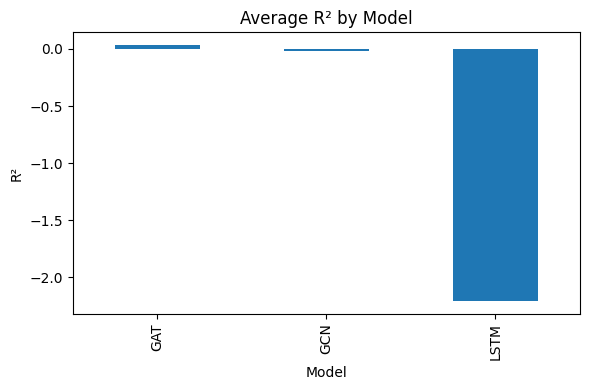

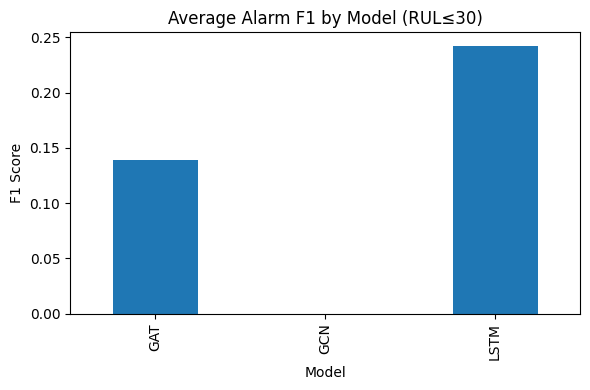

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load extended metrics
df = pd.read_csv('../results/extended_metrics.csv')

# 1) R² bar chart
plt.figure(figsize=(6,4))
df.groupby('Model')['R2'].mean().plot(kind='bar')
plt.title('Average R² by Model')
plt.ylabel('R²')
plt.tight_layout()
plt.savefig('../results/plots/r2_comparison.png')
plt.show()

# 2) Alarm F1 bar chart
plt.figure(figsize=(6,4))
df.groupby('Model')['F1'].mean().plot(kind='bar')
plt.title('Average Alarm F1 by Model (RUL≤30)')
plt.ylabel('F1 Score')
plt.tight_layout()
plt.savefig('../results/plots/alarm_f1_comparison.png')
plt.show()


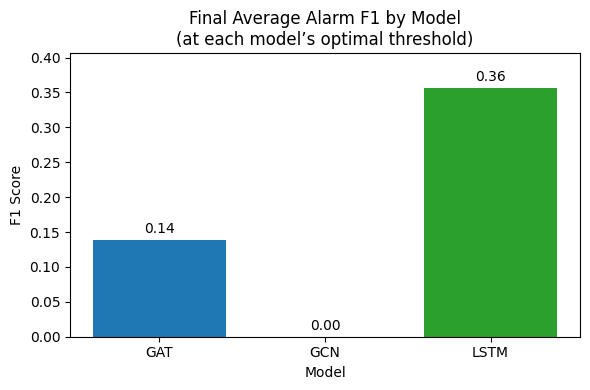

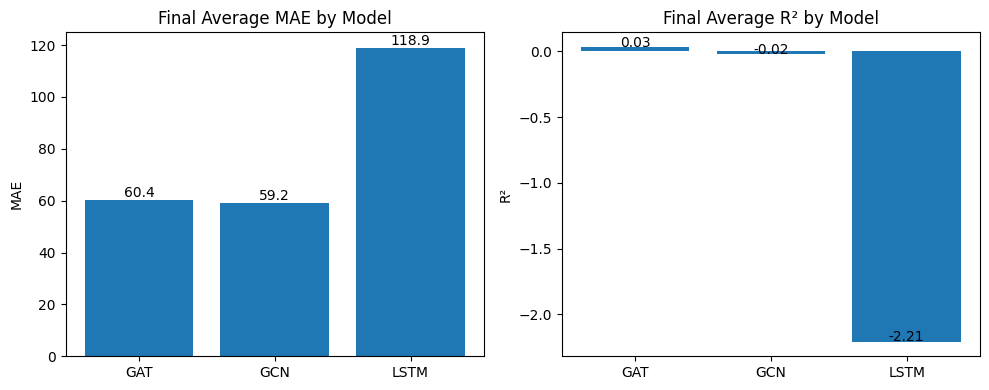

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# If you haven’t already loaded it, do so:
df_final = pd.read_csv('../results/final_metrics_per_model.csv')

# Otherwise, reuse the existing df_final DataFrame from above.

# Compute per-model averages
summary = df_final.groupby('Model').mean().reset_index()

# 1) Bar chart of final Alarm F1
plt.figure(figsize=(6,4))
plt.bar(summary['Model'], summary['F1'], color=['#1f77b4','#ff7f0e','#2ca02c'])
plt.title('Final Average Alarm F1 by Model\n(at each model’s optimal threshold)')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.ylim(0, summary['F1'].max() + 0.05)
for i, v in enumerate(summary['F1']):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')
plt.tight_layout()
plt.savefig('../results/plots/final_alarm_f1.png')
plt.show()

# 2) (Optional) Side-by-side bar chart for MAE and R²
fig, axes = plt.subplots(1, 2, figsize=(10,4))

# MAE
axes[0].bar(summary['Model'], summary['MAE'])
axes[0].set_title('Final Average MAE by Model')
axes[0].set_ylabel('MAE')
for i, v in enumerate(summary['MAE']):
    axes[0].text(i, v + max(summary['MAE'])*0.01, f"{v:.1f}", ha='center')

# R²
axes[1].bar(summary['Model'], summary['R2'])
axes[1].set_title('Final Average R² by Model')
axes[1].set_ylabel('R²')
for i, v in enumerate(summary['R2']):
    axes[1].text(i, v + max(summary['R2'])*0.02, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.savefig('../results/plots/final_mae_r2.png')
plt.show()

**Figure X:** Final average alarm F1 by model at each model’s optimal threshold.  
**Figure Y:** Final average MAE (left) and R² (right) by model.
